# Deep and Cross Neural Networks


Deep and Cross Neural Networks are used in ad-click prediction to help learn feature crosses.

Feature crosses are where features in a model have a stronger impact when they are combined.

Traditional classification models like Logistic Regression and Boosting aren't that effective at capturing interactions.

### Cross Network

![image.png](images/deep_and_cross_network.png)

## Example

In [3]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

__Toy Example__

To illustrate the benefits of DCN, let's work through a simple example. Suppose we have a dataset where we're trying to model the likelihood of a customer clicking on a blender Ad, with its features and label described as follows.

| Features / Label	| Description	                              | Value Type / Range |
| ---               | ---                                         | ---                |
| country	        | the country this customer lives in	      | Int in [0, 199]    |
| bananas	        | # bananas the customer has purchased	      | Int in [0, 23]     |
| cookbooks	        | # cooking books the customer has purchased  | Int in [0, 5]      |
| y                 | the likelihood of clicking on a blender Ad  |                    |

In [4]:
def get_mixer_data(data_size=100_000, random_seed=42):
  # We need to fix the random seed
  # to make colab runs repeatable.
  rng = np.random.RandomState(random_seed)
  country = rng.randint(200, size=[data_size, 1]) / 200.
  bananas = rng.randint(24, size=[data_size, 1]) / 24.
  cookbooks = rng.randint(6, size=[data_size, 1]) / 6.

  x = np.concatenate([country, bananas, cookbooks], axis=1)

  # # Create 1st-order terms.
  y = 0.1 * country + 0.4 * bananas + 0.7 * cookbooks

  # Create 2nd-order cross terms.
  y += 0.1 * country * bananas + 3.1 * bananas * cookbooks + (
        0.1 * cookbooks * cookbooks)

  return x, y

In [5]:
X, y = get_mixer_data()
num_train = 90000
X_train = X[: num_train]
X_test = X[num_train:]
y_train = y[: num_train]
y_test = y[num_train:]

### Model Definition

In [7]:
class Model(tfrs.Model):
    def __init__(self, model):
        super().__init__()
        self._model = model
        self._logit_layer = tf.keras.layers.Dense(1)
        
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[
                tf.keras.metrics.RootMeanSquaredError("RMSE")
            ]
        )
    
    def call(self, x):
        x = self._model(x)
        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        x, labels = features
        scores = self(x)
        return self.task(
            labels=labels,
            predictions=scores
        )
    

Then, we specify the cross network (with 1 cross layer of size 3) and the ReLU-based DNN (with layer sizes [512, 256, 128]):

In [8]:
crossnet = Model(tfrs.layers.dcn.Cross())
deepnet = Model(
    tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu')
    ])
)

### Model Training

In [9]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1000)
eval_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1000)

In [10]:
epochs = 25
learning_rate = 0.4

In [12]:
crossnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
crossnet.fit(train_data, epochs=epochs, verbose=False)

In [13]:
deepnet.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate))
deepnet.fit(train_data, epochs=epochs, verbose=False)

/home/mbarbaric/dev/ai_projects/machine_learning_system_design/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Model Evaluation

In [14]:
crossnet_result = crossnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"CrossNet(1 layer) RMSE is {crossnet_result['RMSE']:.4f} "
      f"using {crossnet.count_params()} parameters.")

deepnet_result = deepnet.evaluate(eval_data, return_dict=True, verbose=False)
print(f"DeepNet(large) RMSE is {deepnet_result['RMSE']:.4f} "
      f"using {deepnet.count_params()} parameters.")

CrossNet(1 layer) RMSE is 0.0057 using 16 parameters.
DeepNet(large) RMSE is 0.0460 using 166401 parameters.


### Model understanding
We already know what feature crosses are important in our data, it would be fun to check whether our model has indeed learned the important feature cross. This can be done by visualizing the learned weight matrix in DCN. The weight 
 represents the learned importance of interaction between feature 
 and 
.

/tmp/ipykernel_29185/2879280353.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
/tmp/ipykernel_29185/2879280353.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_yticklabels([''] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

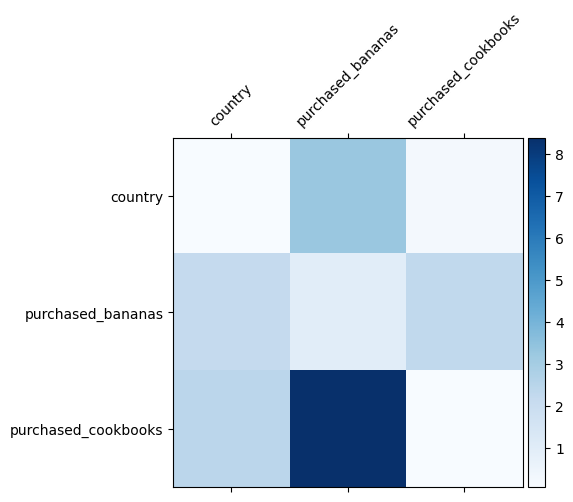

In [15]:
mat = crossnet._model._dense.kernel
features = ["country", "purchased_bananas", "purchased_cookbooks"]

plt.figure(figsize=(9,9))
im = plt.matshow(np.abs(mat.numpy()), cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([''] + features, rotation=45, fontsize=10)
_ = ax.set_yticklabels([''] + features, fontsize=10)

Darker colours represent stronger learned interactions - in this case, it's clear that the model learned that purchasing babanas and cookbooks together is important.